In [ ]:
from google.colab import drive
drive.mount('/content/drive')

SyntaxError: ignored

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
!pip install -q wandb
import wandb

     |████████████████████████████████| 2.1MB 18.5MB/s 
     |████████████████████████████████| 163kB 51.9MB/s 
     |████████████████████████████████| 102kB 13.5MB/s 
     |████████████████████████████████| 133kB 60.0MB/s 
     |████████████████████████████████| 71kB 10.6MB/s 


### Data processing

*We have our image datasets that we use for the CNN. With each on of these batches of images we have a corresponding csv with the image filename, smiles string, and target variable. Because some smiles strings' images didn't make it into the folder we'll get our datasets for the ensembling task by taking our image datasets, and selecting only the smiles strings and target variables for the samples that we got images for (and we can do this by taking the samples from the csv files stored with the images)*

***Loading in the data from the image datasets we made***

In [ ]:
# label csv's removed from image folders so we can traverse through those
# and select the samples we have images for

chris_train_path = '/content/drive/MyDrive/2040_final_project/Molecular Exploration/Data/label_mapping_train.csv'
chris_val_path = '/content/drive/MyDrive/2040_final_project/Molecular Exploration/Data/label_mapping_val.csv'
chris_test_path = '/content/drive/MyDrive/2040_final_project/Molecular Exploration/Data/label_mapping_test.csv'

akshay_train_path = '/content/drive/MyDrive/Molecular Exploration/Data/label_mapping_train.csv'
akshay_val_path = '/content/drive/MyDrive/Molecular Exploration/Data/label_mapping_val.csv'
akshay_test_path = '/content/drive/MyDrive/Molecular Exploration/Data/label_mapping_test.csv'


train_labels = pd.read_csv(akshay_train_path, index_col='Unnamed: 0')
val_labels = pd.read_csv(akshay_val_path, index_col='Unnamed: 0')
test_labels = pd.read_csv(akshay_test_path, index_col = 'Unnamed: 0')

In [ ]:
train_labels

,file,target,smiles
0,0.png,1,CCN1C(=CC=Cc2sc3ccccc3[n+]2CC)Sc2ccccc21.[I-]
1,1.png,1,COC(=O)C[C@](O)(CCCC(C)(C)O)C(=O)O[C@@H]1C(OC)...
2,2.png,0,Cc1cccc(C)c1OCC(C)N.Cl
3,3.png,1,CO.COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)c(OC...
4,4.png,0,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccc(O)cc3)...
...,...,...,...
5787,15582.png,1,Oc1cc(O)cc(/C=C/c2ccc(O)c(O)c2)c1
5788,15586.png,1,Oc1ccc(/C=C/c2ccc(/C=C/c3ccc(O)cc3)c(Br)c2)cc1
5789,15614.png,0,Oc1ccc2ccccc2c1SSc1c(O)ccc2ccccc12
5790,15660.png,0,[Cl-].[Cl-].[Cl-].[Cl-].[Cl-].[Cl-].[NH3+][Ru]...


In [ ]:
# Checking for duplicates in the filename columns of the three datasets --> none found
print(sum([int(b) for b in train_labels.duplicated(subset=['file'])]))
print(sum([int(b) for b in val_labels.duplicated(subset=['file'])]))
print(sum([int(b) for b in test_labels.duplicated(subset=['file'])]))

0
0
0


In [ ]:
import os
import tensorflow as tf

# (Chris's paths)
# train_imgs_path = "/content/drive/MyDrive/2040_final_project/Molecular Exploration/Data/SMILES_train_imgs"
# val_imgs_path = "/content/drive/MyDrive/2040_final_project/Molecular Exploration/Data/SMILES_val_imgs"
# test_imgs_path = "/content/drive/MyDrive/2040_final_project/Molecular Exploration/Data/SMILES_test_imgs"

# (Akshay's paths)
train_imgs_path = "/content/drive/MyDrive/Molecular Exploration/Data/SMILES_train_imgs"
val_imgs_path = "/content/drive/MyDrive/Molecular Exploration/Data/SMILES_val_imgs"
test_imgs_path = "/content/drive/MyDrive/Molecular Exploration/Data/SMILES_test_imgs"

# ======= TRAINING DATA =======

# sequence data
x_train_seq = pd.Series()
# image data --> and we really just need the file name here?
x_train_img = pd.Series()
# need to accumulate the targets too because the indexing will be off
# due to the missing images so we can't just select the subset with a big .iloc
y_train = pd.Series()

for filename in os.listdir(train_imgs_path):
    if filename.endswith(".png"):
        # 1) grab filename row in ____labels dataframe
        row = train_labels[train_labels['file'] == filename]
        # 2) add the smiles to the x series for the sequence model
        x_train_seq = x_train_seq.append(pd.Series(row['smiles']), ignore_index=True)
        # 3) add the filename to the x series for the CNN
        x_train_img = x_train_img.append(pd.Series(row['file']), ignore_index=True)
        # 4) add the target to the y series for the overalll model
        y_train = y_train.append(pd.Series(row['target']))
    else:
        continue

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [ ]:
print(len(x_train_img))
print(len(x_train_seq))
print(len(y_train))

5792
5792
5792


In [ ]:
# ======= VALIDATION DATA =======

# sequence data
x_val_seq = pd.Series()
# image data --> and we really just need the file name here?
x_val_img = pd.Series()
# need to accumulate the targets too because the indexing will be off
# due to the missing images so we can't just select the subset with a big .iloc
y_val = pd.Series()

for filename in os.listdir(val_imgs_path):
    if filename.endswith(".png"):
        # 1) grab filename row in ____labels dataframe
        row = val_labels[val_labels['file'] == filename]
        # 2) add the smiles to the x series for the sequence model
        x_val_seq = x_val_seq.append(pd.Series(row['smiles']), ignore_index=True)
        # 3) add the filename to the x series for the CNN
        x_val_img = x_val_img.append(pd.Series(row['file']), ignore_index=True)
        # 4) add the target to the y series for the overalll model
        y_val = y_val.append(pd.Series(row['target']))
    else:
        continue

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if __name__ == '__main__':


In [ ]:
print(len(x_val_img))
print(len(x_val_seq))
print(len(y_val))

1402
1402
1402


In [ ]:
# ======= TESTING DATA =======

# sequence data
x_test_seq = pd.Series()
# image data --> and we really just need the file name here?
x_test_img = pd.Series()
# need to accumulate the targets too because the indexing will be off
# due to the missing images so we can't just select the subset with a big .iloc
y_test = pd.Series()

for filename in os.listdir(test_imgs_path):
    if filename.endswith(".png"):
        # 1) grab filename row in ____labels dataframe
        row = test_labels[test_labels['file'] == filename]
        # 2) add the smiles to the x series for the sequence model
        x_test_seq = x_test_seq.append(pd.Series(row['smiles']), ignore_index=True)
        # 3) add the filename to the x series for the CNN
        x_test_img = x_test_img.append(pd.Series(row['file']), ignore_index=True)
        # 4) add the target to the y series for the overalll model
        y_test = y_test.append(pd.Series(row['target']))
    else:
        continue

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if __name__ == '__main__':


In [ ]:
print(len(x_test_img))
print(len(x_test_seq))
print(len(y_test))

268
268
268


### Need to tokenize all of the sequence data

*... and of course need to use the same tokenizer as our sequence model was trained with*

***In order to use the exact same preprocessing procedure as before, we'll tape together our smiles and target series into dataframe with those as columns***

In [ ]:
train_df = pd.DataFrame(columns=['smiles','target'])
train_df['smiles'] = x_train_seq
train_df['target'] = y_train

val_df = pd.DataFrame(columns=['smiles','target'])
val_df['smiles'] = x_val_seq
val_df['target'] = y_val

test_df = pd.DataFrame(columns=['smiles','target'])
test_df['smiles'] = x_test_seq
test_df['target'] = y_test

In [ ]:
print(train_df.head())
print(len(train_df))

print(val_df.head())
print(len(val_df))

print(test_df.head())
print(len(test_df))

                               smiles  target
0                 Cc1cc(C)c(N)c(Cl)c1       1
1                            Cc1ccco1       1
2  CC(=O)SCC(CC(=O)c1ccc(C)cc1)C(=O)O       0
3                             CCCCC=O       1
4                       Cc1ccc(Br)cc1       0
5792
                                            smiles  target
0                        CCNC1(c2cccs2)CCCCC1=O.Cl       0
1  COc1ccc2c3c1O[C@H]1C[C@@H](O)C=C[C@@]31CCN(C)C2       1
2                 Cl.O=C(O)/C=C/c1ccc(Cn2ccnc2)cc1       0
3                   CCCC(C)(COC(N)=O)COC(=O)NC(C)C       1
4                   CC(=O)Nc1ccc(OCC(O)CNC(C)C)cc1       1
1402
                                              smiles  target
0                      NC(=O)CNCCC(c1ccccc1)c1ccccc1       0
1  CNc1ccc2oc(C[C@H]3O[C@@]4(CC[C@H]3C)O[C@H]([C@...       1
2  CCCCC#Cc1nc(NC)c2ncn([C@@H]3O[C@H](CO)[C@@H](O...       0
3  [Cl-].[Cl-].[Cl-].[Cl-].[Cl-].[Cl-].[NH3+][Ru]...       0
4                       O=[N+]([O-])c1cccc2cn[nH]c12   

In [ ]:
# copying code from our sequence model notebook...

def read_molnet_df(df):
    texts = []
    labels = []
    for index, row in df.iterrows():
      texts.append(row['smiles'])
      labels.append(row['target'])
    return texts, labels

# train_texts, train_labels = read_molnet_df(train_srp53)
train_texts, train_labels = read_molnet_df(train_df)
val_texts, val_labels = read_molnet_df(val_df)
test_texts, test_labels = read_molnet_df(test_df)

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.1MB 16.2MB/s 
     |████████████████████████████████| 3.3MB 52.5MB/s 
     |████████████████████████████████| 901kB 54.6MB/s 


In [ ]:
from transformers import RobertaTokenizerFast, RobertaTokenizer, AutoTokenizer
tokenizer = RobertaTokenizer.from_pretrained('seyonec/PubChem10M_SMILES_BPE_450k')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
#storing the encodings before manual padding
tokenizer_before = RobertaTokenizer.from_pretrained('seyonec/PubChem10M_SMILES_BPE_450k')

train_encodings_before = tokenizer(train_texts, truncation=True, padding=True)
val_encodings_before = tokenizer(val_texts, truncation=True, padding=True)
test_encodings_before = tokenizer(test_texts, truncation=True, padding=True)

In [ ]:
# manually adding padding to the val and test sets

max_len = len(train_encodings['input_ids'][0])

val_current_len = len(val_encodings['input_ids'][0])
val_pad_len = max_len - val_current_len
val_padding = [1]*val_pad_len
val_encodings['input_ids'] = [pad_list + val_padding for pad_list in val_encodings['input_ids']]

test_current_len = len(test_encodings['input_ids'][0])
test_pad_len = max_len - test_current_len
test_padding = [1]*test_pad_len
test_encodings['input_ids'] = [pad_list + test_padding for pad_list in test_encodings['input_ids']]


In [ ]:
print(len(train_encodings['input_ids'][0]))
print(len(val_encodings['input_ids'][0]))
print(len(test_encodings['input_ids'][0]))

282
282
282


In [ ]:
import tensorflow as tf
class MolNetDataset():
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: tf.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = tf.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset_tf = MolNetDataset(train_encodings, train_labels)
val_dataset_tf = MolNetDataset(val_encodings, val_labels)
test_dataset_tf = MolNetDataset(test_encodings, test_labels)

In [ ]:
# Store the padded encodings in their own objects and abandoning the attention_mask
train_padded = train_encodings['input_ids']
val_padded = val_encodings['input_ids']
test_padded = test_encodings['input_ids']

In [ ]:
padded_x_train = np.expand_dims(np.asarray(train_padded),-1)
padded_x_val = np.expand_dims(np.asarray(val_padded),-1)
padded_x_test = np.expand_dims(np.asarray(test_padded),-1)

In [ ]:
# ... and convert to tensor
tf_x_train = tf.convert_to_tensor(padded_x_train, dtype='float32')
tf_x_val = tf.convert_to_tensor(padded_x_val, dtype='float32')
tf_x_test = tf.convert_to_tensor(padded_x_test, dtype='float32')

In [ ]:
# ... and need to create the y_test and y_train
y_train = np.asarray(train_labels)
y_val = np.asarray(val_labels)
y_test = np.asarray(test_labels)

In [ ]:
# preprocessing the datasets without manual padding
train_dataset_tf_before = MolNetDataset(train_encodings_before, train_labels)
val_dataset_tf_before = MolNetDataset(val_encodings_before, val_labels)
test_dataset_tf_before = MolNetDataset(test_encodings_before, test_labels)

# Store the padded encodings in their own objects and abandoning the attention_mask
train_padded_before = train_encodings_before['input_ids']
val_padded_before = val_encodings_before['input_ids']
test_padded_before = test_encodings_before['input_ids']

padded_x_train_before = np.expand_dims(np.asarray(train_padded_before),-1)
padded_x_val_before = np.expand_dims(np.asarray(val_padded_before),-1)
padded_x_test_before = np.expand_dims(np.asarray(test_padded_before),-1)

tf_x_train_before = tf.convert_to_tensor(padded_x_train_before, dtype='float32')
tf_x_val_before = tf.convert_to_tensor(padded_x_val_before, dtype='float32')
tf_x_test_before = tf.convert_to_tensor(padded_x_test_before, dtype='float32')

# ... and need to create the y_test and y_train
y_train_before = np.asarray(train_labels)
y_val_before = np.asarray(val_labels)
y_test_before = np.asarray(test_labels)

In [ ]:
# checking the shapes of the without manual padding data

print(tf_x_train_before.shape)
print(tf_x_val_before.shape)
print(tf_x_test_before.shape)

(5792, 282, 1)
(1402, 212, 1)
(268, 117, 1)


### Storing the images in memory

*traversing through the set of images and casting each one to a numpy array*

In [ ]:
# save path to access the saved loaded images
# chris path
# SAVE_PATH = '/content/drive/MyDrive/2040_final_project/Molecular Exploration/Data/'

# akshay path
SAVE_PATH = '/content/drive/MyDrive/Molecular Exploration/Data/'

In [ ]:
# from tqdm import tqdm
# import cv2

# x_train_image_values = []

# image_path = '/content/drive/MyDrive/2040_final_project/Molecular Exploration/Data/SMILES_train_imgs/'

# for file in tqdm(x_train_img):
#     image = cv2.imread(image_path+file)
#     x_train_image_values.append(image)

# x_train_image_values = np.array(x_train_image_values)
# print(x_train_image_values.shape)

In [ ]:
# ... and save this huge numpy array to file (we'll save before casting to a tensor
# because it's easy to save from numpy)
# SAVE_PATH = '/content/drive/MyDrive/2040_final_project/Molecular Exploration/Data/'
# np.save(file=SAVE_PATH+'Train_image_numpy_data.npy', arr=x_train_image_values)

In [ ]:
# x_val_image_values = []

# image_path = '/content/drive/MyDrive/2040_final_project/Molecular Exploration/Data/SMILES_val_imgs/'

# for file in tqdm(x_val_img):
#     image = cv2.imread(image_path+file)
#     x_val_image_values.append(image)

# x_val_image_values = np.array(x_val_image_values)
# print(x_val_image_values.shape)

# # save to file
# np.save(file=SAVE_PATH+'Validation_image_numpy_data.npy', arr=x_val_image_values)

In [ ]:
# x_test_image_values = []

# image_path = '/content/drive/MyDrive/2040_final_project/Molecular Exploration/Data/SMILES_test_imgs/'

# for file in tqdm(x_test_img):
#     image = cv2.imread(image_path+file)
#     x_test_image_values.append(image)

# x_test_image_values = np.array(x_test_image_values)
# print(x_test_image_values.shape)

# # save to file
# np.save(file=SAVE_PATH+'Test_image_numpy_data.npy', arr=x_test_image_values)

In [ ]:
## (optionally) LOAD ARRAYS FROM FILE
x_train_image_values = np.load(SAVE_PATH+'Train_image_numpy_data.npy')
x_val_image_values = np.load(SAVE_PATH+'Validation_image_numpy_data.npy')
x_test_image_values = np.load(SAVE_PATH+'Test_image_numpy_data.npy')

# CAST ALL ARRAYS TO TENSORS
x_train_images = tf.convert_to_tensor(x_train_image_values)
x_val_images = tf.convert_to_tensor(x_val_image_values)
x_test_images = tf.convert_to_tensor(x_test_image_values)

### Creating image data generators

*By this point the data is stored as follows:*

- `tf_x_[train/val/test]` : tokenized SMILES sequence data (in tf.tensor)

- `x_[train/val/test]_img` : image file names (in pd.Series)

- `y_[train/val/test]` : labels (in numpy array)

In [ ]:
# wandb.init(project="SMILES_CNN")

#### ***Setting up the image data generators***

In [ ]:
# need the image size so we'll open a single image and get it from that

from PIL import Image
# Open the image form working directory
# chris path
# image = Image.open('/content/drive/MyDrive/2040_final_project/Molecular Exploration/Data/SMILES_train_imgs/0.png')
# akshay path
image = Image.open('/content/drive/MyDrive/Molecular Exploration/Data/SMILES_train_imgs/0.png')
# summarize some details about the image

IMG_SIZE = image.size
BATCH_SIZE = 64

In [ ]:
# Data generators for the image data
data_gen = tf.keras.preprocessing.image.ImageDataGenerator()

# reloading the dataframes for the image data generators
# chris path
# train_labels_img_df = pd.read_csv('/content/drive/MyDrive/2040_final_project/Molecular Exploration/Data/label_mapping_train.csv', index_col='Unnamed: 0')
# val_labels_img_df = pd.read_csv('/content/drive/MyDrive/2040_final_project/Molecular Exploration/Data/label_mapping_val.csv', index_col='Unnamed: 0')
# test_labels_img_df = pd.read_csv('/content/drive/MyDrive/2040_final_project/Molecular Exploration/Data/label_mapping_test.csv', index_col = 'Unnamed: 0')

# akshay path
train_labels_img_df = pd.read_csv('/content/drive/MyDrive/Molecular Exploration/Data/label_mapping_train.csv', index_col='Unnamed: 0')
val_labels_img_df = pd.read_csv('/content/drive/MyDrive/Molecular Exploration/Data/label_mapping_val.csv', index_col='Unnamed: 0')
test_labels_img_df = pd.read_csv('/content/drive/MyDrive/Molecular Exploration/Data/label_mapping_test.csv', index_col = 'Unnamed: 0')

train_labels_img_df['target'] = train_labels_img_df['target'].astype(str)

train_generator = data_gen.flow_from_dataframe(dataframe=train_labels_img_df, 
                                               directory=train_imgs_path,
                                               x_col='file',
                                               y_col='target',
                                               target_size=IMG_SIZE,
                                               batch_size=BATCH_SIZE,
                                               shuffle=False,
                                               class_mode='categorical')

val_labels_img_df['target'] = val_labels_img_df['target'].astype(str)

valid_generator = data_gen.flow_from_dataframe(dataframe=val_labels_img_df, 
                                               directory=val_imgs_path,
                                               x_col='file',
                                               y_col='target',
                                               target_size=IMG_SIZE,
                                               batch_size=BATCH_SIZE,
                                               shuffle=False,
                                               class_mode='categorical')

test_labels_img_df['target']=test_labels_img_df['target'].astype(str)

test_generator = data_gen.flow_from_dataframe(dataframe=test_labels_img_df, 
                                                directory=test_imgs_path,
                                                x_col='file',
                                                y_col='target',
                                                target_size=IMG_SIZE,
                                                batch_size=BATCH_SIZE,
                                                shuffle=False,
                                                class_mode='categorical')

Found 5792 validated image filenames belonging to 2 classes.
Found 1402 validated image filenames belonging to 2 classes.
Found 268 validated image filenames belonging to 2 classes.


***Getting tokenized sequences into data generator -- (actually never mind)***

In [ ]:
seq_dset = tf.data.Dataset.from_tensor_slices(tf_x_train)

In [ ]:
seq_dset

<TensorSliceDataset shapes: (282, 1), types: tf.float32>

In [ ]:
tf_x_train.shape

TensorShape([5792, 282, 1])

In [ ]:
# wandb.init('ensemble')

### Loading in the models and creating comined architecture

In [ ]:
# paths to the models we're combining
# chris paths
# seq_model_path = '/content/drive/MyDrive/2040_final_project/Molecular Exploration/model_checkpoints/ChemBERTa_DeepChem/run_3/sequence_checkpoint-08-0.69.hdf5'
# img_model_path = '/content/drive/MyDrive/2040_final_project/Molecular Exploration/model_checkpoints/SMILES_CNN.hdf5'

# akshay path
seq_model_path = '/content/drive/MyDrive/Molecular Exploration/model_checkpoints/ChemBERTa_DeepChem/run_3/sequence_checkpoint-08-0.69.hdf5'
img_model_path = '/content/drive/MyDrive/Molecular Exploration/model_checkpoints/SMILES_CNN.hdf5'


In [ ]:
tf.keras.backend.clear_session()

In [ ]:
seq_model = tf.keras.models.load_model(seq_model_path)
img_model = tf.keras.models.load_model(img_model_path)

In [ ]:
models = [seq_model.output, img_model.output]

seq_model._name = 'sequence_mod'
img_model._name = 'image_mod'

***Defining the input layers***

***Removing the last two layers from both networks***

In [ ]:
from keras.models import Model

seq_model_embedding = Model(inputs=seq_model.input, outputs=seq_model.layers[-2].output)
img_model_embedding = Model(inputs=img_model.input, outputs=img_model.layers[-2].output)

In [ ]:
seq_model_embedding.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_input (InputLayer)   [(None, None, 1)]         0         
_________________________________________________________________
masking (Masking)            (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 512)         528384    
_________________________________________________________________
dropout (Dropout)            (None, None, 512)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 512)         1574912   
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 512)         0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 512)         157491

In [ ]:
print(seq_model_embedding.layers[-1])
print(seq_model.layers[-2])

In [ ]:
print(img_model_embedding.layers[-1])
print(img_model.layers[-2])

***Building the model***

In [ ]:
# checking output dimension of the two base models
print(seq_model_embedding.layers[-1].output_shape)
print(img_model_embedding.layers[-1].output_shape)

(None, 64)
(None, 1536)


In [ ]:
from tensorflow import keras
from keras.layers import *

In [ ]:
# want to shrink the image output down from 1500 to 64, so will pass through a single dense layer
x = Dense(64)(img_model_embedding.output) 
img_model_shrunk = Model(inputs=img_model_embedding.input, outputs=x)

In [ ]:
img_model_shrunk.output_shape

(None, 64)

In [ ]:
# defining input layers for the two submodels
sequence_input = tf.keras.layers.Input(shape=(tf_x_train.shape[1], tf_x_train.shape[2], 1))
sequence_input._name = 'seq_input'
image_input = tf.keras.layers.Input(shape=(x_train_images.shape[1], x_train_images.shape[2], 3))
image_input._name = 'img_input'

In [ ]:
# defining composite model
seq_model_base_output = seq_model_embedding(sequence_input)
img_model_base_output = img_model_shrunk(image_input)

ensemble_layer = keras.layers.Concatenate()([seq_model_base_output, img_model_base_output])
intermed_layer = Dense(32, activation='relu', kernel_regularizer='l2')(ensemble_layer)
output = Dense(1, activation='sigmoid')(intermed_layer)
ensemble_model = keras.Model(inputs = [sequence_input, image_input], outputs = output)

In [ ]:
ensemble_model.layers[0]._name = 'sequence_input'
ensemble_model.layers[1]._name = 'image_input'

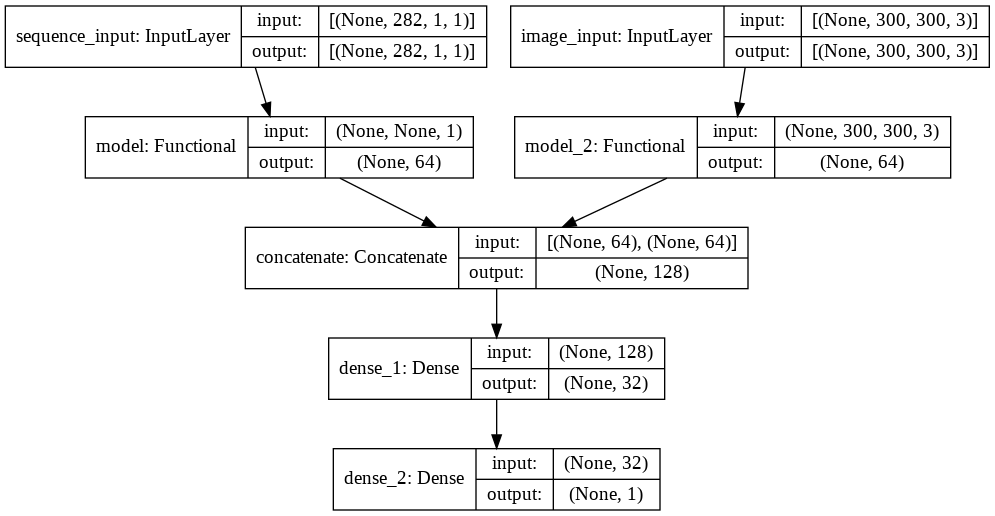

In [ ]:
keras.utils.plot_model(ensemble_model, show_shapes=True)

***Feeding the data in in parallel with dictionary being passed to fit method:***

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# save_path = '/content/drive/MyDrive/2040_final_project/Molecular Exploration/model_checkpoints/'
# chris path
# save_path = '/content/drive/MyDrive/DATA_2040/Molecular Exploration/model_checkpoints/ChemBERTa_DeepChem/'

# akshay path
save_path = '/content/drive/MyDrive/Molecular Exploration/model_checkpoints/ensemble/'

save_name = "ensemble_checkpoint-{epoch:02d}-{val_auc:.2f}.hdf5"     
checkpoint = ModelCheckpoint(save_path+save_name,
                             monitor = "val_auc",
                             mode = "max",
                             save_best_only = True,
                             verbose = 1,
                             save_weights_only = True)
earlystop = EarlyStopping(monitor = 'val_auc', 
                          min_delta = 0.001, 
                          patience = 15,
                          verbose = 1,
                          restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_auc',
                              factor = 0.8,
                              patience = 4,
                              verbose = 1,
                              min_delta = 0.0001,
                              min_lr = 0.00000001)
callbacks = [checkpoint, reduce_lr, earlystop]

In [ ]:
auc_metric = tf.keras.metrics.AUC()

opt = tf.keras.optimizers.Adam(learning_rate=0.005)

# class_weight = {0: 1, 1: 15}

ensemble_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy',auc_metric])

ensemble_history = ensemble_model.fit(
    x={"sequence_input": tf_x_train, "image_input": x_train_images},
    y=y_train,
    validation_data=([tf_x_val, x_val_images],y_val),
    steps_per_epoch = 5,
    validation_steps = 5,
    # class_weight=class_weight,
    epochs=10,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/10
5/5 [==============================] - ETA: 0s - loss: 2.4837 - accuracy: 0.6756 - auc_5: 0.3174

ValueError: ignored

In [ ]:
# wandb.finish()

In [ ]:
# save model history using pickle
import pickle

file = open('/content/drive/MyDrive/Molecular Exploration/model_checkpoints/ensemble/results/ensemble_history.save', 'wb')
pickle.dump(ensemble_history, file)
file.close()

### Example weight loading

In [ ]:
# ensemble_layer_example = keras.layers.Concatenate()([seq_model_base_output, img_model_base_output])
# intermed_layer_example = Dense(32, activation='relu', kernel_regularizer='l2')(ensemble_layer_example)
# output_example = Dense(1, activation='sigmoid')(intermed_layer_example)
# ensemble_model_example = keras.Model(inputs = [sequence_input, image_input], outputs = output_example)
# ensemble_model_example.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy',auc_metric])

In [ ]:
# ensemble_model_example.evaluate({"sequence_input": tf_x_test, "image_input": x_test_images}, y_test)

In [ ]:
# ensemble_model_example.load_weights('/content/drive/MyDrive/Molecular Exploration/model_checkpoints/ensemble/sequence_checkpoint-02-0.52.hdf5')

In [ ]:
# ensemble_model_example.evaluate({"sequence_input": tf_x_test, "image_input": x_test_images}, y_test)

### Checking sequence model

In [ ]:
from keras.models import *

In [ ]:
def rnn_bert_model():

  model = Sequential()
  model.add(Masking(mask_value=0.0))

  model.add(Bidirectional(LSTM(256,  
                return_sequences = True),
              #    kernel_initializer=GlorotNormal,
                input_shape=(tf_x_train.shape[1],tf_x_train.shape[2])))
  
  model.add(Dropout(0.25))
  model.add(Bidirectional(LSTM(256, return_sequences = True)))
  model.add(Dropout(0.25))
  model.add(Bidirectional(LSTM(256, return_sequences = True)))

  model.add(Conv1D(64, 
                   kernel_size=3, 
                   padding='valid', 
                   kernel_initializer='glorot_uniform'))
  
  model.add(GlobalAveragePooling1D())
  model.add(Dense(1, activation='sigmoid'))

  # common metric for the binary classification problem: AUC
  auc_metric = tf.keras.metrics.AUC()
  opt = tf.keras.optimizers.Adam(learning_rate=0.01)

  model.compile(loss='binary_crossentropy', 
                optimizer=opt, 
                metrics=['accuracy', auc_metric])

  model.build(input_shape=(None,
                           tf_x_train.shape[1],
                           tf_x_train.shape[2]))
  print(model.summary())

  return model


model = rnn_bert_model()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_2 (Masking)          (None, 282, 1)            0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 282, 512)          528384    
_________________________________________________________________
dropout_4 (Dropout)          (None, 282, 512)          0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 282, 512)          1574912   
_________________________________________________________________
dropout_5 (Dropout)          (None, 282, 512)          0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 282, 512)          1574912   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 280, 64)          

In [ ]:


earlystop = EarlyStopping(monitor = 'val_auc', 
                          min_delta = 0.001, 
                          patience = 15,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_auc',
                              factor = 0.8,
                              patience = 4,
                              verbose = 1,
                              min_delta = 0.0001,
                              min_lr = 0.00000001)

callbacks = [earlystop, reduce_lr]

model.fit(tf_x_train_before, 
          y_train, 
          validation_data=(tf_x_val_before, y_val),
          epochs=100,
          batch_size=128,
          # class_weight={0: negative, 1: positive},
          callbacks=[reduce_lr]
          )

Epoch 1/100
46/46 [==============================] - 186s 4s/step - loss: 4.1580 - accuracy: 0.8168 - auc_2: 0.5110 - val_loss: 0.2923 - val_accuracy: 0.9451 - val_auc_2: 0.4618
Epoch 2/100
46/46 [==============================] - 154s 3s/step - loss: 0.2478 - accuracy: 0.9338 - auc_2: 0.6108 - val_loss: 0.2551 - val_accuracy: 0.9451 - val_auc_2: 0.4626
Epoch 3/100
46/46 [==============================] - 153s 3s/step - loss: 0.2321 - accuracy: 0.9363 - auc_2: 0.6363 - val_loss: 0.2393 - val_accuracy: 0.9451 - val_auc_2: 0.4631
Epoch 4/100
14/46 [========>.....................] - ETA: 1:45 - loss: 0.2044 - accuracy: 0.9470 - auc_2: 0.5992

KeyboardInterrupt: ignored